In [1]:
# This is an implementation of Contrastive Explanations in Neural Networks.
# The code is built on top of Grad-CAM explanations. The base implementation of Grad-CAM is derived from :
# https://github.com/1Konny/gradcam_plus_plus-pytorch

import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from PIL import Image
import time
import glob
import math

from utils import visualize_cam, Normalize
from gradcam import GradCAM, Contrast

ModuleNotFoundError: No module named 'utils'

## Load imagenet data

In [2]:
from torchvision import datasets
import random
data_handler = datasets.ImageFolder(root="C:/Users/julia/OneDrive/Dokumente/GitHub/development/files/imagenetv2-matched-frequency-format-val")

In [8]:
def sample_random_images(data_handler, number, seed=None):
    images = []
    img_paths = data_handler.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = data_handler.loader(rand_img_path)
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
    return np.array(images)

In [9]:
x_test = sample_random_images(data_handler, 5, 5)

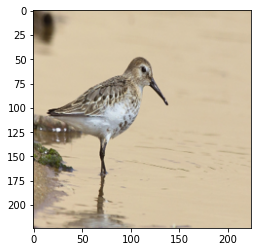

In [10]:
plt.imshow(x_test[3])

In [11]:
img_name = "Vogel.jpg"

## Load image from repo examples

In [7]:
img_dir = 'Images'
#img_name = 'water-bird.JPEG'
img_name = 'Flamingo6.jpg'
#img_name = 'cat_dog.png'


img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)

## Preprocess pillow image to torch

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255) # .cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)

normed_torch_img = normalizer(torch_img)

## Preprocess numpy image to torch

In [12]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_img = torch.from_numpy(x_test[3]).permute(2, 0, 1).unsqueeze(0).float().div(255) # .cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)

normed_torch_img = normalizer(torch_img)

C:\Users\julia\anaconda3\envs\xai_env\lib\site-packages\torch\nn\functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [13]:
output_dir = 'Results'
folder1 = 'GradCam'
folder2 = 'Contrast'

os.makedirs(output_dir + '/' + folder1 + '/', exist_ok=True)
os.makedirs(output_dir + '/' + folder2 + '/', exist_ok=True)

cam_dict = dict()

# Please select any of the networks. Your own networks and data can also be used. In that case, the layer specifications
# should be provided below (layer_name), and extraction should be done in utils.py
# As an example we demo on VGG-16, layer 29

vgg = models.vgg16(pretrained=True)
vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg.eval()#, vgg.cuda()

# Example configurations of other architectures are shown below

#resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer4', input_size=(224, 224))
#alexnet_model_dict = dict(type='alexnet', arch=model, layer_name='features_11', input_size=(224, 224))
#densenet_model_dict = dict(type='densenet', arch=model, layer_name='features_norm5', input_size=(224, 224))
#squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))

vgg_gradcam = GradCAM(vgg_model_dict, False)
vgg_contrast = Contrast(vgg_model_dict, True)

mask_gradcam, logit = vgg_gradcam(normed_torch_img)
heatmap_gradcam, result_gradcam = visualize_cam(mask_gradcam, torch_img)

output_path = os.path.join(output_dir + '/' + folder1 + '/' + img_name)
save_image(result_gradcam, output_path)

mask_contrast, _ = vgg_contrast(normed_torch_img, 130)  # Your choice of contrast; The Q in `Why P, rather than Q?'. Class 130 is flamingo
heatmap_contrast, result_contrast = visualize_cam(mask_contrast, torch_img)

output_path = os.path.join(output_dir + '/' + folder2 + '/' + img_name)
save_image(result_contrast, output_path)

C:\Users\julia\anaconda3\envs\xai_env\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


saliency_map size : torch.Size([14, 14])
